# Attempting some basic aperture photometry (yeet)

Based on method used in previous source detection test

First up, dependencies:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from photutils import DAOStarFinder
from photutils import CircularAperture, CircularAnnulus
from photutils import aperture_photometry
from matplotlib.colors import LogNorm
#from astropy.visualization import SqrtStretch
#from astropy.visualization.mpl_normalize import ImageNormalize

Importing .fits file and extracting the ~ *data* ~:

In [4]:
image_file = 'example_data/PAL5_3p6um.fits'
image_data = fits.getdata(image_file, ext=0)
#print(image_data.shape)

hdu_list = fits.open(image_file)
hdr = hdu_list[0].header
#data = hdu_list[0].data   # could open data here instead of fits.getdata above, more consistent
gain = hdr['GAIN']         # don't need gain any more
exptime = hdr['EXPTIME']
fluxconv = hdr['FLUXCONV']
print(gain, exptime, fluxconv)
hdu_list.close()

3.71 969.101928711 0.1469


Locating the objects in the image using DAOStarFinder, and plotting no. of stars detected vs. sigma curve:

In [47]:
#def detect_sources(data, sigma_level, FWHM):
#    daofind = DAOStarFinder(threshold = sigma_level * std, fwhm=FWHM)
#    sources = daofind(data - median)
#    return sources

In [76]:
mean, median, std = sigma_clipped_stats(data, sigma=3.) # don't need mean any more?

#detect_sources(data, sigma_level=5., FWHM=3.)
#for col in sources.colnames:
#    sources[col].info.format = '%.8g'
#print(sources)

#for i in range(1, 8):
#    detect_sources(data, sigma_level=float(i), FWHM=3.)
#    print(len(sources))

no_detected = []
sigma_vals = []
    
for i in np.arange(1., 15.5, 0.5):
    #print(i)
    daofind = DAOStarFinder(threshold = i * std, fwhm = 3.)
    sources = daofind(data - median)
    #print(len(sources))
    
    no_detected.append(len(sources))
    sigma_vals.append(i)

print(no_detected)
print(sigma_vals)

[12439, 6925, 3986, 2574, 1861, 1448, 1225, 1058, 944, 864, 810, 754, 709, 667, 632, 593, 557, 523, 500, 488, 464, 437, 427, 411, 386, 371, 357, 348, 340]
[1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0, 11.5, 12.0, 12.5, 13.0, 13.5, 14.0, 14.5, 15.0]


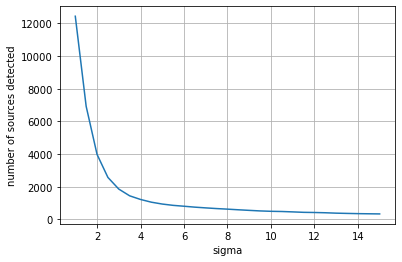

In [64]:
plt.plot(sigma_vals, no_detected)
plt.xlabel('sigma')
plt.ylabel('number of sources detected')
plt.grid(True)
plt.savefig('images/sigma_curve_01.png', dpi=100)

Adding the centroid positions of the objects to an array and fitting circular apertures and annuli around them:

C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


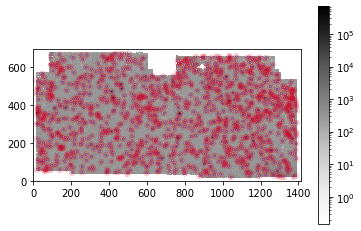

In [72]:
daofind = DAOStarFinder(threshold = 4. * std, fwhm = 3.)  # 4 sigma seems ideal to me
sources = daofind(data - median)

pos = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(pos, r=6.)
annuli = CircularAnnulus(pos, r_in=6., r_out=14.)
all_apers = [apertures, annuli]
norm = LogNorm()
plt.imshow(data, cmap='Greys', origin='lower', norm=norm, interpolation='nearest')
plt.colorbar()
apertures.plot(color='blue', lw=.5, alpha=.5)
annuli.plot(color='red', lw=.5, alpha=.5)

#plt.title('4 sigma')
#plt.savefig('images/sigma_4.png', dpi=500)

Performing some basic aperture photometry, summing the pixel brightness values (fluxes?) inside each aperture and annulus:

(Note: 'nan' values for apertures could be where the objects are too close to the edge of the image and use some pure white in their summation, and those for the annuli might be where annuli overlap?)

In [13]:
phot_table = aperture_photometry(data, all_apers)
for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'
print(phot_table)

 id  xcenter   ycenter  aperture_sum_0 aperture_sum_1
       pix       pix                                 
--- --------- --------- -------------- --------------
  1  1374.715  21.00836            nan            nan
  2 1306.2872 21.691519            nan            nan
  3  875.5912 26.690492            nan            nan
  4 1269.2458 28.561558      92495.088            nan
  5 929.15178 29.723225      37404.056            nan
  6 1140.0222 29.913012      68417.435            nan
  7 1302.2448 30.489824      157632.94            nan
  8 890.49164 34.446212      36457.077      158338.43
  9 989.51277 35.887709      45001.038       159571.9
 10 799.47603 39.338704            nan            nan
...       ...       ...            ...            ...
935 1071.7977 658.65453            nan            nan
936 91.637048 658.52925            nan            nan
937 1035.1634 660.07166            nan            nan
938 370.50076 660.02253      64689.982      180624.47
939 409.61314 662.66578     

Finding which star coordinates are giving me attitude and plotting them:

875
69


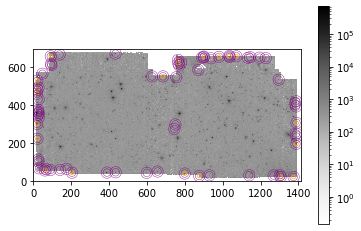

In [75]:
fail_test_x_ap = []
fail_test_y_ap = []
fail_test_x_an = []
fail_test_y_an = []
many_men_had_tried_to_take_him_and_that_many_men_were_dead = []
#nice_data = []

for i in range(0, len(phot_table)):
    if np.isnan(phot_table['aperture_sum_0'][i]) == True:
        fail_test_x_ap.append(phot_table['xcenter'][i].value)
        fail_test_y_ap.append(phot_table['ycenter'][i].value)
    if np.isnan(phot_table['aperture_sum_1'][i]) == True:
        fail_test_x_an.append(phot_table['xcenter'][i].value)
        fail_test_y_an.append(phot_table['ycenter'][i].value)
    else:
        nice_data.append(phot_table[:][i])

fail_test_all_ap = np.column_stack((fail_test_x_ap, fail_test_y_ap))
fail_test_all_an = np.column_stack((fail_test_x_an, fail_test_y_an))
aperture_fails = CircularAperture(fail_test_all_ap, r=10.)
annulus_fails = CircularAnnulus(fail_test_all_an, r_in=20., r_out=30.)
#print(len(aperture_fails), len(annulus_fails))

#print(fail_test_all_ap)
#print(fail_test_all_an)
#print(nice_data)

plt.imshow(data, cmap='Greys', origin='lower', norm=norm, interpolation='nearest')
plt.colorbar()
aperture_fails.plot(color='orange', lw=.7, alpha=1.)
annulus_fails.plot(color='purple', lw=.4, alpha=1.)

#plt.savefig('images/ap_photom_fail_stars_04.png', dpi=500)

Estimating the local background in the annuli by finding the mean brightness within:

In [15]:
bkg_mean = phot_table['aperture_sum_1'] / annuli.area
bkg_sum = bkg_mean * apertures.area
final_sum = phot_table['aperture_sum_0'] - bkg_sum

phot_table['residual_sum_mean'] = final_sum
for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'
print(phot_table)

 id  xcenter   ycenter  aperture_sum_0 aperture_sum_1 residual_sum_mean
       pix       pix                                                   
--- --------- --------- -------------- -------------- -----------------
  1  1374.715  21.00836            nan            nan               nan
  2 1306.2872 21.691519            nan            nan               nan
  3  875.5912 26.690492            nan            nan               nan
  4 1269.2458 28.561558      92495.088            nan               nan
  5 929.15178 29.723225      37404.056            nan               nan
  6 1140.0222 29.913012      68417.435            nan               nan
  7 1302.2448 30.489824      157632.94            nan               nan
  8 890.49164 34.446212      36457.077      158338.43         830.92974
  9 989.51277 35.887709      45001.038       159571.9         9097.3615
 10 799.47603 39.338704            nan            nan               nan
...       ...       ...            ...            ...           

Alternate method: better stats yay (sigma-clipped median in the annuli):

In [16]:
annulus_masks = annuli.to_mask(method='center') # note: exact would be overkill for local bkg estimation (read ap phot tutorial for explanation)

bkg_median = []
for mask in annulus_masks:
    annulus_data = mask.multiply(data)
    annulus_data_1d = annulus_data[mask.data > 0]
    _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
    bkg_median.append(median_sigclip)

bkg_median = np.array(bkg_median)
phot = aperture_photometry(data, apertures)
phot['annulus_median'] = bkg_median
phot['aper_bkg'] = bkg_median * apertures.area
phot['aper_sum_bkgsub'] = phot['aperture_sum'] - phot['aper_bkg']

for col in phot.colnames:
    phot[col].info.format = '%.8g'
print(phot)

 id  xcenter   ycenter  aperture_sum annulus_median  aper_bkg aper_sum_bkgsub
       pix       pix                                                         
--- --------- --------- ------------ -------------- --------- ---------------
  1  1374.715  21.00836          nan      767.60413 86813.981             nan
  2 1306.2872 21.691519          nan      941.07599 106433.19             nan
  3  875.5912 26.690492          nan      313.18938 35420.884             nan
  4 1269.2458 28.561558    92495.088      639.06165 72276.169       20218.918
  5 929.15178 29.723225    37404.056      294.53822 33311.488       4092.5678
  6 1140.0222 29.913012    68417.435      408.80429 46234.676       22182.759
  7 1302.2448 30.489824    157632.94      894.32312 101145.56       56487.381
  8 890.49164 34.446212    36457.077      312.03087  35289.86       1167.2173
  9 989.51277 35.887709    45001.038      316.91534 35842.281       9158.7572
 10 799.47603 39.338704          nan      332.17505 37568.113   

In [17]:
f = open('file.txt', 'wb')
for col in phot.colnames:
    f.write(phot[col])